In [1]:
from gensim.models import Word2Vec
from gensim.parsing.preprocessing import remove_stopwords
from database.pymysql_conn import DataBase
import pandas as pd
import numpy as np
import re
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
plt.style.use('ggplot')

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
np.random.seed(777)

In [3]:
db = DataBase()

In [4]:
SQL = """
SELECT COUNT(*),
       appid,
       DATEDIFF(publishedAt, release_date),
       gameName,
       release_date,
       DATE(publishedAt)
FROM (SELECT T1.appid, T1.avg_player_count, T1.gameName, T1.release_date ,
             T2.publishedAt,
             DATEDIFF(T2.publishedAt, T1.release_date)
      FROM (SELECT A.appid, A.gameName, A.avg_player_count,
                   B.release_date
            FROM (SELECT *
                  FROM yt.games) A
                   JOIN (SELECT appid,
                                name,
                                MAX(release_date) AS release_date
                         FROM oasis.app_info2
                         GROUP BY appid) AS B ON A.appid = B.appid) T1
             LEFT JOIN (SELECT appid,
                               gameName,
                               text,
                               publishedAt
                        FROM steam.yt_comment
                        WHERE filter = 0
                          AND language = 'en') T2 ON T1.appid = T2.appid
      WHERE DATEDIFF(T2.publishedAt, T1.release_date) <= 300) Base
GROUP BY DATE(publishedAt), appid
ORDER BY DATEDIFF(publishedAt, release_date), appid;

"""

In [5]:
df = db.to_df(SQL)

In [6]:
df

,COUNT(*),appid,"DATEDIFF(publishedAt, release_date)",gameName,release_date,DATE(publishedAt)
0,1,1091010,-3131,Dark Swords,2019-06-21,2010-11-24
1,1,1048540,-3124,Kao the Kangaroo Round 2,2019-06-01,2010-11-11
2,1,1091010,-3011,Dark Swords,2019-06-21,2011-03-24
3,1,314650,-2993,SpaceEngine,2019-06-11,2011-04-01
4,1,1048540,-2897,Kao the Kangaroo Round 2,2019-06-01,2011-06-26
...,...,...,...,...,...,...
15248,3,911400,293,Assassins Creed III Remastered,2019-03-30,2020-01-17
15249,1,911400,294,Assassins Creed III Remastered,2019-03-30,2020-01-18
15250,1,958260,294,DEAD OR ALIVE Xtreme Venus Vacation,2019-03-26,2020-01-14
15251,1,886820,295,Nelke the Legendary Alchemists Ateliers of th...,2019-03-26,2020-01-15


In [7]:
len(df['gameName'].unique())

59

## All Games

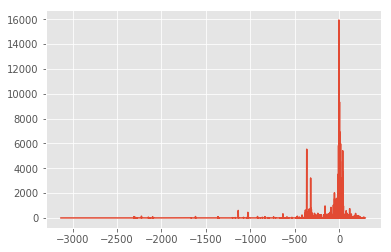

In [8]:
plt.plot(df['DATEDIFF(publishedAt, release_date)'], df['COUNT(*)'])

In [9]:
df_under100 = df[df['DATEDIFF(publishedAt, release_date)']>=-100]

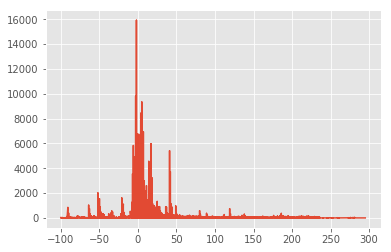

In [10]:
plt.plot(df_under100['DATEDIFF(publishedAt, release_date)'], df_under100['COUNT(*)'])

In [11]:
success = ["Dota Underlords",
            "Borderlands GOTY Enhanced",
            "Anno 1800",
            "F1 2019",
            "DEAD OR ALIVE Xtreme Venus Vacation",
            "RAGE 2",
            "OCTOPATH TRAVELER",
            "Lords Mobile",
            "Pro Cycling Manager 2019",
            "Ironsight",
            "Yakuza Kiwami 2", # 10
            "Pagan Online",
            "Monster Girl Island Prologue",
            "Winning Post 9",
            "Assassins Creed III Remastered",
            "Otakus Adventure",
            "SUPER DRAGON BALL HEROES WORLD MISSION",
            "AVA Dog Tag"] # 500++

In [12]:
df_success = df[df['gameName'].isin(success)]
df_fail = df[~df['gameName'].isin(success)]

## Success Games

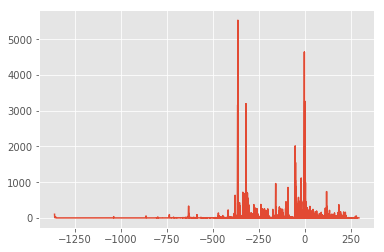

In [13]:
plt.plot(df_success['DATEDIFF(publishedAt, release_date)'], df_success['COUNT(*)'])

## Fail Games

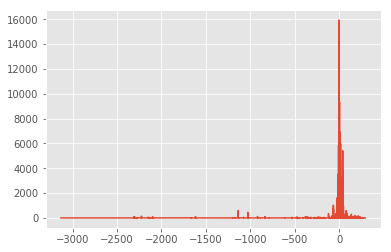

In [14]:
plt.plot(df_fail['DATEDIFF(publishedAt, release_date)'], df_fail['COUNT(*)'])

In [15]:
success_games = [df[df['gameName']==game] for game in [game for game in success]]

In [16]:
len(df['gameName'].unique())

59

In [34]:
success_games[0]['gameName'].iloc[0]

'Dota Underlords'

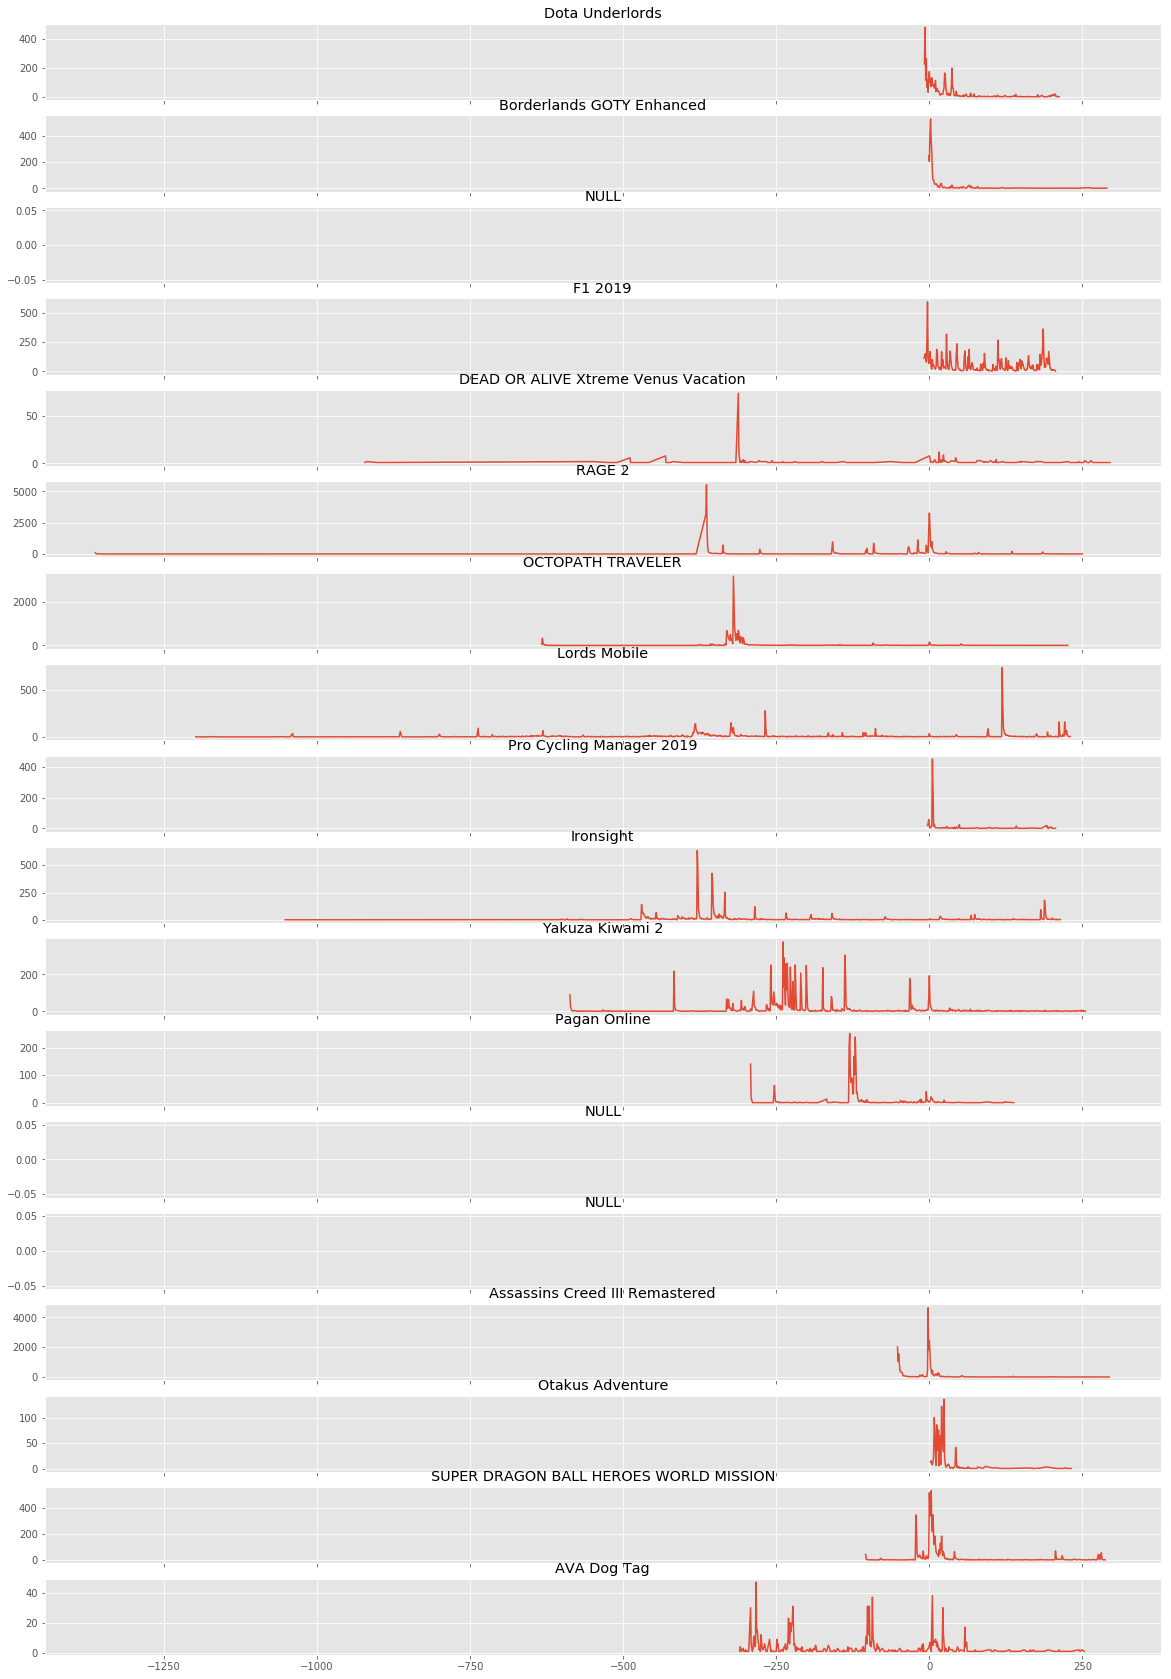

In [37]:
fig, axs = plt.subplots(18, sharex=True, figsize=(20,30))
for i, game in enumerate(success_games):
    try:
        gameName = game['gameName'].iloc[0]
    except IndexError:
        gameName = "NULL"
    axs[i].set_title(gameName)
    axs[i].plot(game['DATEDIFF(publishedAt, release_date)'], game['COUNT(*)'])